In [2]:
import h5py
import pandas as pd
import numpy as np
import time
import warnings
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA, KernelPCA
from sklearn import preprocessing
from sklearn.metrics import roc_curve, accuracy_score, auc, confusion_matrix
from scipy.stats import randint, poisson

import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm import early_stopping
from sklearn.metrics import accuracy_score

def load_data(name):
    with h5py.File(f'{name}.h5', 'r') as f:
        filename = name.split('/')[1]
        return pd.DataFrame(f[filename][:], dtype=np.float64)

train = load_data('data/train')
test  = load_data('data/test')

In [3]:
print (f'Shape of training data set: {train.shape}')
print (f'Shape of test data set: {test.shape}')

Shape of training data set: (162500, 166)
Shape of test data set: (160651, 164)


In [4]:
all_variables = ['actualInteractionsPerCrossing', 'averageInteractionsPerCrossing', 'correctedActualMu', 'correctedAverageMu', 'correctedScaledActualMu', 'correctedScaledAverageMu', 'NvtxReco', 'p_nTracks', 'p_pt_track', 'p_eta', 'p_phi', 'p_charge', 'p_qOverP', 'p_z0', 'p_d0', 'p_sigmad0', 'p_d0Sig', 'p_EptRatio', 'p_dPOverP', 'p_z0theta', 'p_etaCluster', 'p_phiCluster', 'p_eCluster', 'p_rawEtaCluster', 'p_rawPhiCluster', 'p_rawECluster', 'p_eClusterLr0', 'p_eClusterLr1', 'p_eClusterLr2', 'p_eClusterLr3', 'p_etaClusterLr1', 'p_etaClusterLr2', 'p_phiClusterLr2', 'p_eAccCluster', 'p_f0Cluster', 'p_etaCalo', 'p_phiCalo', 'p_eTileGap3Cluster', 'p_cellIndexCluster', 'p_phiModCalo', 'p_etaModCalo', 'p_dPhiTH3', 'p_R12', 'p_fTG3', 'p_weta2', 'p_Reta', 'p_Rphi', 'p_Eratio', 'p_f1', 'p_f3', 'p_Rhad', 'p_Rhad1', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_TRTPID', 'p_TRTTrackOccupancy', 'p_numberOfInnermostPixelHits', 'p_numberOfPixelHits', 'p_numberOfSCTHits', 'p_numberOfTRTHits', 'p_numberOfTRTXenonHits', 'p_chi2', 'p_ndof', 'p_SharedMuonTrack', 'p_E7x7_Lr2', 'p_E7x7_Lr3', 'p_E_Lr0_HiG', 'p_E_Lr0_LowG', 'p_E_Lr0_MedG', 'p_E_Lr1_HiG', 'p_E_Lr1_LowG', 'p_E_Lr1_MedG', 'p_E_Lr2_HiG', 'p_E_Lr2_LowG', 'p_E_Lr2_MedG', 'p_E_Lr3_HiG', 'p_E_Lr3_LowG', 'p_E_Lr3_MedG', 'p_ambiguityType', 'p_asy1', 'p_author', 'p_barys1', 'p_core57cellsEnergyCorrection', 'p_deltaEta0', 'p_deltaEta2', 'p_deltaEta3', 'p_deltaPhi0', 'p_deltaPhi1', 'p_deltaPhi2', 'p_deltaPhi3', 'p_deltaPhiFromLastMeasurement', 'p_deltaPhiRescaled0', 'p_deltaPhiRescaled1', 'p_deltaPhiRescaled3', 'p_e1152', 'p_e132', 'p_e235', 'p_e255', 'p_e2ts1', 'p_ecore', 'p_emins1', 'p_etconeCorrBitset', 'p_ethad', 'p_ethad1', 'p_f1core', 'p_f3core', 'p_maxEcell_energy', 'p_maxEcell_gain', 'p_maxEcell_time', 'p_maxEcell_x', 'p_maxEcell_y', 'p_maxEcell_z', 'p_nCells_Lr0_HiG', 'p_nCells_Lr0_LowG', 'p_nCells_Lr0_MedG', 'p_nCells_Lr1_HiG', 'p_nCells_Lr1_LowG', 'p_nCells_Lr1_MedG', 'p_nCells_Lr2_HiG', 'p_nCells_Lr2_LowG', 'p_nCells_Lr2_MedG', 'p_nCells_Lr3_HiG', 'p_nCells_Lr3_LowG', 'p_nCells_Lr3_MedG', 'p_pos', 'p_pos7', 'p_poscs1', 'p_poscs2', 'p_ptconeCorrBitset', 'p_ptconecoreTrackPtrCorrection', 'p_r33over37allcalo', 'p_topoetconeCorrBitset', 'p_topoetconecoreConeEnergyCorrection', 'p_topoetconecoreConeSCEnergyCorrection', 'p_weta1', 'p_widths1', 'p_widths2', 'p_wtots1', 'p_e233', 'p_e237', 'p_e277', 'p_e2tsts1', 'p_ehad1', 'p_emaxs1', 'p_fracs1', 'p_DeltaE', 'p_E3x5_Lr0', 'p_E3x5_Lr1', 'p_E3x5_Lr2', 'p_E3x5_Lr3', 'p_E5x7_Lr0', 'p_E5x7_Lr1', 'p_E5x7_Lr2', 'p_E5x7_Lr3', 'p_E7x11_Lr0', 'p_E7x11_Lr1', 'p_E7x11_Lr2', 'p_E7x11_Lr3', 'p_E7x7_Lr0', 'p_E7x7_Lr1' ]

In [5]:
train = train[train.Truth != 0]

bv = [22, 33, 12, 52, 84, 115, 99, 25, 82, 135, 17, 130, 8, 14, 92, 7, 147, 144, 145, 16]
best_variables = []
for i in range(len(bv)): #converting into variable names
    best_variables.append(all_variables[bv[i]])

X = train[best_variables]
y = train['p_truth_E']

X_real = test[best_variables]
    
#making a cut of the data
n = 120000
idxs = np.arange(train.shape[0])
idxs_rand = np.random.choice(idxs, size=n)
train_cut = train.iloc[idxs_rand]

X_cut = train_cut[best_variables]
y_cut = train_cut['p_truth_E']

#transform = preprocessing.StandardScaler()
#X_std = transform.fit_transform(X)

input_train, input_test, truth_train, truth_test = train_test_split(X_cut, y_cut, test_size=0.25, random_state=42)

print (f'Shape of X: {X.shape}')
print (f'Shape of y: {y.shape}')
print (f'Shape of X_real: {X_real.shape}')

Shape of X: (121495, 20)
Shape of y: (121495,)
Shape of X_real: (160651, 20)


# LightGBM Regressor

In [17]:
start = time.time()
clf = LGBMRegressor(max_depth=13, min_samples_leaf=35, n_estimators=1000)
clf.fit(input_train, truth_train, eval_set=[(input_test, truth_test)], early_stopping_rounds=50, verbose=-1)
end = time.time()

print(f"Time used: {(end-start)*1000:.1f} ms")
print(f"Accuracy : {clf.score(input_test, truth_test)}")
print(clf.score(input_train, truth_train))
y_real = clf.predict(X_real, num_iteration=clf.best_iteration_)

C:\Users\night\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\night\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=35. Current value: min_data_in_leaf=35
Time used: 2585.3 ms
Accuracy : 0.9501223145491636
0.9752484570519555


In [18]:
results_clf = pd.DataFrame(y_real)
#results_clf.to_csv('solutions/Regression_SW_lgbmreg.txt', sep=',', header=False)

bvdf = pd.DataFrame(best_variables)
#bvdf.to_csv('solutions/Regression_SW_lgbmreg_VariableList.txt', sep=',', header=False, index=False)

In [7]:
parameters_RandomSearch = {'max_depth': poisson(25), 
                           'min_samples_leaf': randint(20, 50)}
warnings.filterwarnings("ignore")
n_iter_search = 20
RandomSearch = RandomizedSearchCV(clf, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,
                                  verbose=-1,
                                  return_train_score=True,
                                  random_state=42,
                                 )

In [8]:
warnings.filterwarnings("ignore")
RandomSearch.fit(input_train, truth_train); #takes a long time to run!
RandomSearch_results = pd.DataFrame(RandomSearch.cv_results_)                 
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.3f}")

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=30. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=30. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=30. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=30. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=30. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=45. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_sa

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=31. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=31. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=31. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=31. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=31. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=33. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_sa

In [ ]:
35, 9, 0.923
22, 23, 0.923
17, 36, 0.923
25, 33
13, 35, 0.921

In [13]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=35. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=35. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=35. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=35. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=35. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=35. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_sa

In [57]:
print(scores)

[0.93706232 0.92688054 0.90363051 0.91489458 0.9132291 ]


# Neural Network Method

In [ ]:
from sklearn.neural_network import MLPRegressor
transform = preprocessing.StandardScaler()
train_std = transform.fit_transform(input_train)
test_std = transform.fit_transform(input_test)
X_std = transform.fit_transform(X_real)

start = time.time()
clf_nn = MLPRegressor(max_iter=1000,
                    n_iter_no_change=50,           # Number of iterations without improvement before stopping
                    solver='adam',                  # Standard for minimising
                    activation='relu',          # Standard function (but slightly slower)
                    hidden_layer_sizes=(20, 20),    # Size of network (same as ALEPH)
                    learning_rate='adaptive',     # Other options are "constant" and "adaptive"
                    learning_rate_init=0.02,
                    early_stopping=True,
                    random_state=42)
clf_nn.fit(train_std, truth_train)
ynnreal = clf_nn.predict(X_std)
# Print the time usage:
end = time.time()
print(f"Time used by MLPClassifier: {(end-start)*1000:.1f} ms")
#y_score_MLP = clf_nn.predict_proba(test_std)
accuracy = clf_nn.score(test_std, truth_test)
print(accuracy)
tg = clf_nn.score(train_std, truth_train)
print(tg)

In [17]:
import random
parameters_RandomSearch = {'learning_rate_init': np.linspace(0.001,0.01,10)}
warnings.filterwarnings("ignore")
n_iter_search = 10
RandomSearch = RandomizedSearchCV(clf_nn, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,
                                  verbose=-1,
                                  return_train_score=True,
                                  random_state=42,
                                 )

In [ ]:
warnings.filterwarnings("ignore")
RandomSearch.fit(train_std, truth_train); #takes a long time to run!
RandomSearch_results = pd.DataFrame(RandomSearch.cv_results_)                 
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.3f}")

In [20]:
y_nn = pd.DataFrame(ynnreal)
print(y_nn)
results_nn = y_nn
#results_nn.to_csv('solutions/Regression_SW_mlp_nn.txt', sep=',', header=False)

                    0
0        85884.722452
1        92712.618080
2       229863.267954
3       111699.674694
4        91272.808149
...               ...
160646  221962.149015
160647  133139.601511
160648  119693.292576
160649   96414.490682
160650  159121.439637

[160651 rows x 1 columns]


In [68]:
from sklearn.inspection import permutation_importance

r = permutation_importance(clf_nn, test_std, y=truth_test, n_repeats=20, random_state=12)  #takes a long time to run! 

In [59]:
bv3 = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0 and r.importances_mean[i] > 0.0007 and i in bv:
        print(f"{i:<12}" f"{all_variables[i]:<48}"   f"{r.importances_mean[i]:.3f}" f" +/- {r.importances_std[i]:.3f}    *")
        bv3.append(i)
    elif r.importances_mean[i] - 2 * r.importances_std[i] > 0 and r.importances_mean[i] >= 0.0007:
        print(f"{i:<12}" f"{all_variables[i]:<48}"   f"{r.importances_mean[i]:.3f}" f" +/- {r.importances_std[i]:.3f}")
        bv3.append(i)

0           actualInteractionsPerCrossing                   0.771 +/- 0.024
1           averageInteractionsPerCrossing                  0.049 +/- 0.003
6           NvtxReco                                        0.035 +/- 0.002
7           p_nTracks                                       0.022 +/- 0.002    *
9           p_eta                                           0.013 +/- 0.003
8           p_pt_track                                      0.013 +/- 0.001    *
10          p_phi                                           0.010 +/- 0.001
18          p_dPOverP                                       0.008 +/- 0.001
17          p_EptRatio                                      0.007 +/- 0.001    *
5           correctedScaledAverageMu                        0.005 +/- 0.001
16          p_d0Sig                                         0.004 +/- 0.001    *
15          p_sigmad0                                       0.003 +/- 0.001
11          p_charge                                        0.002 +/

In [60]:
bv3

[0, 1, 6, 7, 9, 8, 10, 18, 17, 5, 16, 15, 11]

In [147]:
#core57cellsenergycorrection

len(bv2)

18

In [156]:
len(bv)

20

In [157]:
print(bv)

['p_eCluster', 'p_eAccCluster', 'p_qOverP', 'p_deltaEta1', 'p_deltaEta2', 'p_nCells_Lr1_HiG', 'p_ecore', 'p_rawECluster', 'p_core57cellsEnergyCorrection', 'p_widths1', 'p_EptRatio', 'p_r33over37allcalo', 'p_pt_track', 'p_d0', 'p_deltaPhiRescaled1', 'p_nTracks', 'p_E3x5_Lr1', 'p_fracs1', 'p_DeltaE', 'p_d0Sig']


In [162]:
print(best_variables)

['p_eCluster', 'p_eAccCluster', 'p_qOverP', 'p_deltaEta1', 'p_deltaEta2', 'p_nCells_Lr1_HiG', 'p_ecore', 'p_rawECluster', 'p_core57cellsEnergyCorrection', 'p_widths1', 'p_EptRatio', 'p_r33over37allcalo', 'p_pt_track', 'p_d0', 'p_deltaPhiRescaled1', 'p_nTracks', 'p_E3x5_Lr1', 'p_fracs1', 'p_DeltaE', 'p_d0Sig']


In [186]:
def plot_pca(y_pcs, y):
    #=== plot PCA results
    fig, ax = plt.subplots(1, figsize=(10, 10), dpi=100)
    #ax.set_xlim(np.percentile(y_pcs[:,0], 99), np.percentile(y_pcs[:,0], 1))
    #ax.set_ylim(np.percentile(y_pcs[:,1], 99), np.percentile(y_pcs[:,1], 1))
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

    # locate the points of each type in the original data
    # and paint them over the transformed data
    is_type1 = (y == 0)
    is_type2 = (y == 1)
    is_type3 = (y == 2)
    ax.scatter(y_pcs[is_type1, 0], y_pcs[is_type1, 1], 
               c='y', marker='s', label='Type 1')
    ax.scatter(y_pcs[is_type2, 0], y_pcs[is_type2, 1], 
               c='b', marker='o', label='Type 2')
    ax.scatter(y_pcs[is_type3, 0], y_pcs[is_type3, 1], 
               c='g', marker='^', label='Type 3')
    ax.scatter(y_pcs[0], y_pcs[1])
    ax.legend()
    plt.show()
    return 

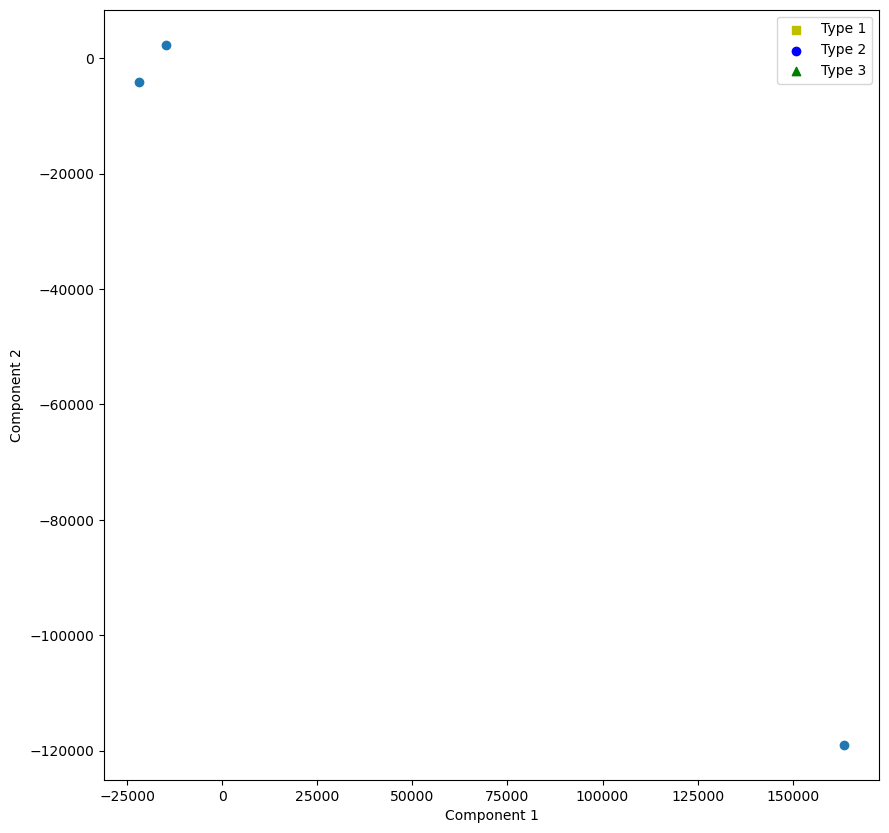

array([[ -21752.16985399,  163457.87615831,  -14703.95839143],
       [  -4217.98428548, -118994.51770287,    2325.41774125],
       [ -14382.71446957,   86634.56701184,  -12582.16635246],
       ...,
       [  -3574.18776044,  -70526.70162405,     416.38954858],
       [ -11815.84965731,  -39345.21868054,   -4120.7929282 ],
       [   2657.9789349 ,  152752.55320076,  -18183.25114027]])

In [188]:
pca = PCA(n_components=3, svd_solver='full') # get a pca object of class PCA()
y_pcs = pca.fit_transform(input_train) # train pca object

# plot PCA results
plot_pca(y_pcs, truth_train)
y_pcs